In [128]:
from numpy import *
from numpy import pi as π
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive

In [129]:
def Rx(a):
    """ Matriz de rotação em torno do eixo x por um ângulo a (em radianos). """
    return array([
        [1, 0, 0],
        [0, cos(a), -sin(a)],
        [0, sin(a), cos(a)]
    ])

def Ry(b):
    """ Matriz de rotação em torno do eixo y por um ângulo b (em radianos). """
    return array([
        [cos(b), 0, sin(b)],
        [0, 1, 0],
        [-sin(b), 0, cos(b)]
    ])

def Rz(c):
    """ Matriz de rotação em torno do eixo z por um ângulo c (em radianos). """
    return array([
        [cos(c), -sin(c), 0],
        [sin(c), cos(c), 0],
        [0, 0, 1]
    ])

def Rtot(a, b, c):
    """ Combinar rotações em torno dos eixos x, y e z. """
    return dot(Rz(c), dot(Ry(b), Rx(a)))

In [ ]:
class GaussianBeam:
    """
    This class is used to represent a General Astigmatic Gaussian Beam.
    """
    def __init__(self,P:float64,λ:float64,q10:complex128,q20:complex128,θ:complex128):
        self.P = P
        self.λ = λ
        self.q1 = lambda z: z + q10.real + 1.j*q10.imag
        self.q2 = lambda z: z + q20.real + 1.j*q20.imag
        self.θ = θ

        self.k = 2.*π/λ
        self.Q = lambda z: array([
            [(cos(θ)**2.)/self.q1(z) + (sin(θ)**2.)/self.q2(z),      0.5*sin(2.*θ)*(1./self.q1(z) - 1./self.q2(z))],
            [0.5*sin(2.*θ)*(1./self.q1(z - 1./self.q2(z))),      (sin(θ)**2.)/self.q1(z) + (cos(θ)**2.)/self.q2(z)]
        ],complex128)
        self.E0 = lambda z: sqrt(P/λ*sqrt(
            4.*self.Q(z)[1,1].imag)*self.Q(z)[2,2].imag - (self.Q(z)[1,2] + self.Q(z)[2,1])**2.
        )
        self.η = lambda z: 0.5*(atan(self.q1(z).real/self.q1(z).imag) + atan(self.q2(z).real/self.q2(z).imag))
        self.E = lambda r,z: self.E0(z)*exp(1.j*self.η(z) - 1.j*(self.k/2.)*(r.T @ self.Q(z) @ r))

    def get_elipses_parameters(self,z):
        """
        This function is used to calculate the ral parameters needed for intensity and phase ellipses to be drawn
        """

        α = self.θ.real
        β = self.θ.imag
        
        ρ1 = self.q1(z).real/(abs(self.q1(z))**2.)
        ρ2 = self.q2(z).real/(abs(self.q2(z))**2.)

        ω1 = self.q1(z).imag/(abs(self.q1(z))**2.)
        ω2 = self.q2(z).imag/(abs(self.q2(z))**2.)

        return α, β, ρ1, ρ2, ω1, ω2
    
    def intensity_ellipse(self, z):
        """
        This function returns the semi axis and rotation of the intensity elipse.
            
        The intensity elipse (defined by φ_w, w1 and w2 - the angle of rotation and semi-axis) is drawn on the
        plane paralel to xy and containing the informed z point on the axis z, and define the waist shape on the
        corresponding z point.
        """

        α, β, ρ1, ρ2, ω1, ω2 = self.get_elipses_parameters(z)

        φ_w0 = 0.5*arctan2(-(ρ1 - ρ2)*tanh(2.*β),(ω1 - ω2))
        φ_w = unwrap(φ_w0 + α, period=π)

        w1 = 1./sqrt((self.k/4.)*(ω1 + ω2 + sqrt(((ω1 - ω2)**2.)*(cosh(2*β)**2.) + ((ρ1 - ρ2)**2.)*(sinh(2*β)**2.))))
        w2 = 1./sqrt((self.k/4.)*(ω1 + ω2 - sqrt(((ω1 - ω2)**2.)*(cosh(2*β)**2.) + ((ρ1 - ρ2)**2.)*(sinh(2*β)**2.))))

        return φ_w, w1, w2
        
    def phase_ellipse(self, z):
        """
        This function returns the semi axis and rotation of the phase elipse.

        The phase elipse is the elipsoid of curvature matrix:
        C = [[1/R1, 0],[0, 1/R2]]
        on its own coordinate system located at the informed z, with local z equal to global z but axis x and y
        rotated by φ_R around z. This elipsoide is tangent to the point z with concavity directed to the origin of
        the global axis.
        """

        α, β, ρ1, ρ2, ω1, ω2 = self.get_elipses_parameters(z)

        φ_R0 = 0.5*arctan2( (ω1 - ω2)*tanh(2.*β),(ρ1 - ρ2))
        φ_R = unwrap(φ_R0 + α, period=π)

        R1 = 2./(ρ1 + ρ2 + sqrt(((ρ1 - ρ2)**2.)*(cosh(2*β)**2.) + ((ω1 - ω2)**2.)*(sinh(2*β)**2.)))
        R2 = 2./(ρ1 + ρ2 - sqrt(((ρ1 - ρ2)**2.)*(cosh(2*β)**2.) + ((ω1 - ω2)**2.)*(sinh(2*β)**2.)))

        return φ_R, R1, R2
    
    def wavefront_surfaces(self, z, n_points=50):
        """
        This function uses the intensity and phase elipses to calculate wavefronts within the beam waist as
        surfaces with the curvature given by the phase ellipse data and waist given by the intensity elipse data.
        """
        rot2d = lambda a, b, ang: (
            Rz(ang) @ vstack([a.flatten(), b.flatten(), zeros_like(a.flatten())])).reshape((3, *a.shape))[:2, :, :]
        
        φ_w, w1, w2 = self.intensity_ellipse(z)
        φ_R, R1, R2 = self.phase_ellipse(z)

        θ = linspace(0., 2*π, n_points)
        ρ = linspace(0., 1., n_points)

        Θ, P = meshgrid(θ, ρ)

        surfaces = []
        for zi, w1i, w2i, φ_wi, R1i, R2i, φ_Ri in zip(z, w1, w2, φ_w, R1, R2, φ_R):
            Xw = w1i * P * cos(Θ)
            Yw = w2i * P * sin(Θ)

            X, Y = rot2d(Xw, Yw, φ_wi)

            XR, YR = rot2d(X, Y, -φ_Ri)
            Z = zi - (0.5 * (XR ** 2.) / R1i + 0.5 * (YR ** 2.) / R2i)

            surfaces.append([X,Y,Z])

        return surfaces


In [131]:
from numpy import *
import plotly.graph_objects as go

λ = 1064e-9
q1 = 66e-3j
q2 = -500e-3 + 266e-3j
θ = (20. + 10.j)*π/180.

gb = GaussianBeam(1,λ,q1,q2,θ)

z = linspace(-1,1,10)
surfaces = gb.wavefront_surfaces(z)

fig = go.Figure()

for surface in surfaces:
    X,Y,Z = surface
    
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        opacity=0.5,
        showscale=False,
        colorscale='reds',
        showlegend=False
    ))

fig.update_layout(
    title="Visualização 3D da Cintura e Elipsoide de Curvatura",
    scene=dict(
        xaxis=dict(title='X (m)'),
        yaxis=dict(title='Y (m)'),
        zaxis=dict(title='Z (m)')
    ),
    autosize=False,
    width=800,
    height=600
)


In [132]:
# from numpy import *
# import plotly.graph_objects as go

# λ = 1064e-9
# q1 = 66e-3j
# q2 = -500e-3 + 266e-3j
# θ = (20. + 10.j)*π/180.

# gb = GaussianBeam(1,λ,q1,q2,θ)

# # Exemplo de dados (deve ser substituído pelos seus dados reais)
# z = linspace(-1,1,10)

# waist_data, phase_data = gb.intensity_phase_ellipses(z)
# φ_w, w1, w2 = waist_data
# φ_R, R1, R2 = waist_data

# # Criar o gráfico
# fig = go.Figure()

# for zi, w1i, w2i, φ_wi, R1i, R2i, φ_Ri in zip(z, w1, w2, φ_w, R1, R2, φ_R):
#     # Gerando a superfície elipsoidal
#     u = linspace(-3 * w1i, 3 * w1i, 50)
#     v = linspace(-3 * w2i, 3 * w2i, 50)
#     U, V = meshgrid(u, v)
#     X = U
#     Y = V
#     Z = zi - 0.5*U**2 / R1i - 0.5*V**2 / R2i
    
#     # Rotacionar a superfície elipsoidal para o espaço global
#     rotated = dot(Rz(φ_Ri), vstack([X.flatten(), Y.flatten(), Z.flatten()]))
#     X_rot, Y_rot, Z_rot = rotated.reshape((3, *U.shape))

#     X_inv, Y_inv, _ = dot(Rz(-φ_wi), vstack([X_rot.flatten(), Y_rot.flatten(), zeros_like(X_rot.flatten())]))
#     X_inv = X_inv.reshape(U.shape)
#     Y_inv = Y_inv.reshape(V.shape)
    
#     # Máscara para o perfil do feixe
#     mask = (X_inv**2 / w1i**2 + Y_inv**2 / w2i**2 >= 1)
    
#     fig.add_trace(go.Surface(
#         x=X_rot,
#         y=Y_rot,
#         z=Z_rot,
#         opacity=0.5,
#         showscale=False,
#         colorscale='reds',
#         showlegend=False
#     ))

# fig.update_layout(
#     title="Visualização 3D da Cintura e Elipsoide de Curvatura",
#     scene=dict(
#         xaxis=dict(title='X (m)'),
#         yaxis=dict(title='Y (m)'),
#         zaxis=dict(title='Z (m)')
#     ),
#     autosize=False,
#     width=800,
#     height=600
# )



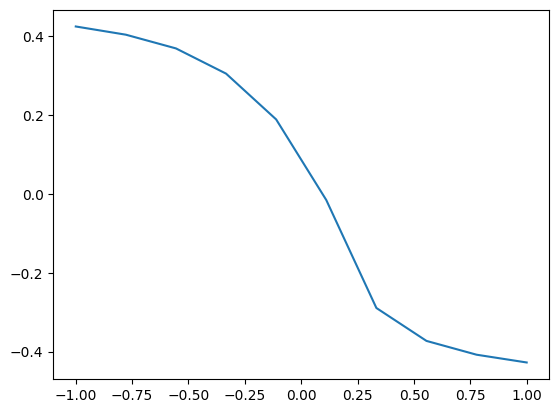

In [133]:
plt.plot(z,(φ_w)/π)